In [ ]:
#Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import cv2
import glob
from skimage import feature

from skimage.metrics import structural_similarity as ssim
from sewar.full_ref import rmse, psnr, uqia

# Import helper functions from utils.py
import utils 

#Save path 
save_path = r"E:\SNU Chennai\projects\IVP\edge-detection-metrics\Evaluation metrics"

# Global variables
channels = ['Coastal \nAerosol','Blue','Green',
                 'Red','Red Edge 1','Red Edge 2',
                'Red Edge 3','NIR','Red Edge 4',
                 'Water \nVapour','SWIR 1','SWIR 2']

thresholds = [[50,100],[50,150],[100,200],[100,300],[200,400],[200,600]] 

In [9]:
# Reload utils
import importlib
importlib.reload(utils)


<module 'utils' from 'e:\\SNU Chennai\\projects\\IVP\\edge-detection-metrics\\src\\utils.py'>

In [10]:
test_path = glob.glob(r"E:\SNU Chennai\projects\IVP\edge-detection-metrics\SWED\SWED\test\images\*")
print(test_path[0])
print(len(test_path))

# Initialise data processing class
processor = utils.data_processor()

def get_input(paths):
    # Load all images and labels
    input = []
    rgb = []
    labels = []

    for path in paths:
        try:
            img, rgb_img, label = processor.load_test(path)
        
            input.append(img)
            labels.append(label)
            rgb.append(rgb_img)
        except:
            print("Error with image: ", path)

    # Apply canny edge detection to binary maps to get reference edges
    canny_input = [np.uint8(img*255) for img in labels]
    edge_reference = [np.uint8(cv2.Canny(img,threshold1 = 100, threshold2 = 200)) for img in canny_input]

    return input, rgb, labels, edge_reference

input, rgb, labels, edge_reference = get_input(test_path)



E:\SNU Chennai\projects\IVP\edge-detection-metrics\SWED\SWED\test\images\S2A_MSIL2A_20190312T031541_N0211_R118_T48QYJ_20190312T083550_image_0_0.tif
98


21
0 255


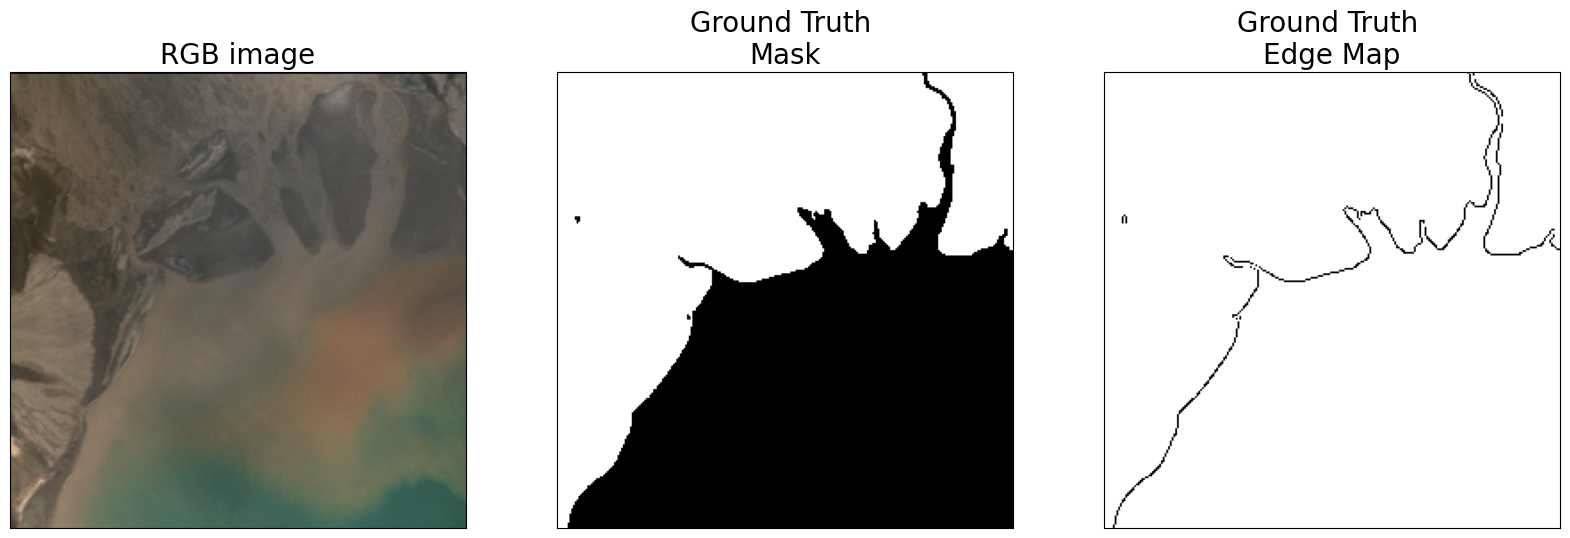

In [11]:
# Sense check edge references
rint = np.random.randint(0,len(edge_reference))
print(rint)
fig, ax = plt.subplots(1,3, figsize=(20,20))
fig.set_facecolor('white')

ax[0].imshow(rgb[rint])
ax[0].set_title('RGB image',size=20)
ax[1].imshow(1-labels[rint] ,  cmap='gray')
ax[1].set_title('Ground Truth \nMask',size=20)
ax[2].imshow(255-edge_reference[rint], cmap='gray')
ax[2].set_title('Ground Truth \nEdge Map',size=20)

for a in ax:
    a.set_xticks([])
    a.set_yticks([])

print(np.min(edge_reference[rint]) ,np.max(edge_reference[rint]))

plt.savefig(save_path + '\\Figures\\dataset_example.png', dpi=300, bbox_inches='tight')

In [12]:
# Apply canny edge detection with different intensity thresholds
def get_canny(input):
        canny_input = input.copy()
        canny = {}

        for threshold in thresholds:
                t1 = threshold[0]
                t2 = threshold[1]
                canny[str(threshold)] = [processor.canny_ed(img,threshold1=t1,threshold2=t2) for img in canny_input]

                print(threshold, len(canny[str(threshold)]),'done')

        return canny

canny = get_canny(input)

[50, 100] 98 done
[50, 150] 98 done
[100, 200] 98 done
[100, 300] 98 done
[200, 400] 98 done
[200, 600] 98 done


In [13]:
# Evaluate canny edge detection with rmse, psnr, uqi, ssim and fom and confusion matrix measures
rows = []

for threshold in thresholds:
    canny_output = canny[str(threshold)]

    for i, output in enumerate(canny_output):
        ref_img = edge_reference[i]
        #ID = "IMG#{}".format(i)
        ID = i
        for j in range(len(channels)):
                
            img = output[:,:,j]

            # Evaluation metrics
            rmse_ = rmse(ref_img,img)
            psnr_ = psnr(ref_img,img)
            uqi_ = uqi(ref_img,img)
            ssim_ = ssim(ref_img,img,multichannel=True)
            fom_ = processor.fom(ref_img,img)
            tp_,fp_,tn_,fn_,tpr_,fpr_,tnr_,fnr_,fp_fn_ratio_ = processor.get_rates(ref_img,img)

            # detect edges as a percentage of reference edges
            pde_ = np.count_nonzero(img)/np.count_nonzero(ref_img)
            
            row = [ID,tuple(threshold),j+ 1,rmse_,psnr_,uqi_,ssim_,fom_,tp_,fp_,tn_,fn_,tpr_,fpr_,tnr_,fnr_,fp_fn_ratio_,pde_]
            rows.append(row)

    print(threshold,'done')
    
df_metrics = pd.DataFrame(rows,columns = ['ID',"thresholds","band","rmse","psnr","uqi","ssim","fom","tp","fp","tn","fn","tpr","fpr","tnr","fnr","fp_fn_ratio","pde"])
df_metrics.to_csv(save_path+"\\canny_evaluation_metrics.csv")
df_metrics.head()

[50, 100] done
[50, 150] done
[100, 200] done
[100, 300] done
[200, 400] done
[200, 600] done


,ID,thresholds,band,rmse,psnr,uqi,ssim,fom,tp,fp,tn,fn,tpr,fpr,tnr,fnr,fp_fn_ratio,pde
0,0,"(50, 100)",1,65.945619,11.747085,0.632636,0.642106,0.468588,219,2172,60934,2211,0.090123,0.034418,0.965582,0.909877,0.982361,0.983951
1,0,"(50, 100)",2,66.701103,11.648143,0.666557,0.676951,0.478589,387,2441,60665,2043,0.159259,0.038681,0.961319,0.840741,1.194812,1.163786
2,0,"(50, 100)",3,67.462835,11.549512,0.670723,0.679588,0.485946,445,2602,60504,1985,0.183128,0.041232,0.958768,0.816872,1.310831,1.253909
3,0,"(50, 100)",4,72.960042,10.869102,0.654382,0.655838,0.498404,730,3665,59441,1700,0.300412,0.058077,0.941923,0.699588,2.155882,1.808642
4,0,"(50, 100)",5,64.937368,11.880910,0.679872,0.685506,0.543737,566,2386,60720,1864,0.232922,0.037809,0.962191,0.767078,1.280043,1.214815


In [16]:
# Sobel thresholds (single-value gradient magnitude)
sobel_thresholds = [50, 100, 150, 200, 250, 300]

# Apply Sobel edge detection with thresholding
def get_sobel(input_images):
    sobel_input = input_images.copy()
    sobel = {}

    for thresh in sobel_thresholds:
        results = []
        for img in sobel_input:
            sobel_img = processor.preprocess(img)  # normalize per band
            out = np.zeros_like(sobel_img)
            for i in range(12):  # 12 bands
                band = sobel_img[:, :, i]
                sobel_band = processor.sobel_ed(band)
                # Apply post-magnitude threshold
                _, binary = cv2.threshold(sobel_band, thresh, 255, cv2.THRESH_BINARY)
                out[:, :, i] = binary
            results.append(out)
        sobel[str(thresh)] = results
        print(f"Threshold {thresh}: {len(results)} images processed.")
    return sobel

sobel = get_sobel(input)

Threshold 50: 98 images processed.
Threshold 100: 98 images processed.
Threshold 150: 98 images processed.
Threshold 200: 98 images processed.
Threshold 250: 98 images processed.
Threshold 300: 98 images processed.


In [17]:
# Evaluate Sobel output using metrics
rows = []

for threshold in sobel_thresholds:
    sobel_output = sobel[str(threshold)]

    for i, output in enumerate(sobel_output):
        ref_img = edge_reference[i]
        ID = i

        for j in range(len(channels)):
            img = output[:, :, j]

            # Evaluation metrics
            rmse_ = rmse(ref_img, img)
            psnr_ = psnr(ref_img, img)
            uqi_ = uqi(ref_img, img)
            ssim_ = ssim(ref_img, img, multichannel=True)
            fom_ = processor.fom(ref_img, img)
            tp_, fp_, tn_, fn_, tpr_, fpr_, tnr_, fnr_, fp_fn_ratio_ = processor.get_rates(ref_img, img)
            pde_ = np.count_nonzero(img) / np.count_nonzero(ref_img)

            row = [ID, threshold, j + 1, rmse_, psnr_, uqi_, ssim_, fom_,
                   tp_, fp_, tn_, fn_, tpr_, fpr_, tnr_, fnr_, fp_fn_ratio_, pde_]
            rows.append(row)

    print(f"Threshold {threshold} done")

# Save to CSV
df_metrics_sobel = pd.DataFrame(rows, columns=[
    'ID', "thresholds", "band", "rmse", "psnr", "uqi", "ssim", "fom",
    "tp", "fp", "tn", "fn", "tpr", "fpr", "tnr", "fnr", "fp_fn_ratio", "pde"
])

df_metrics_sobel.to_csv(save_path + "\\sobel_evaluation_metrics.csv")
df_metrics_sobel.head()

Threshold 50 done
Threshold 100 done
Threshold 150 done
Threshold 200 done
Threshold 250 done
Threshold 300 done


,ID,thresholds,band,rmse,psnr,uqi,ssim,fom,tp,fp,tn,fn,tpr,fpr,tnr,fnr,fp_fn_ratio,pde
0,0,50,1,81.782876,9.877556,0.602335,0.605672,0.482932,504,4815,58291,1926,0.207407,0.076300,0.923700,0.792593,2.500000,2.188889
1,0,50,2,81.982812,9.856347,0.639063,0.646740,0.498820,754,5098,58008,1676,0.310288,0.080785,0.919215,0.689712,3.041766,2.408230
2,0,50,3,83.565083,9.690307,0.650053,0.658329,0.491598,786,5394,57712,1644,0.323457,0.085475,0.914525,0.676543,3.281022,2.543210
3,0,50,4,93.282465,8.734803,0.624688,0.626157,0.493568,1127,7467,55639,1303,0.463786,0.118325,0.881675,0.536214,5.730622,3.536626
4,0,50,5,91.959470,8.858874,0.647549,0.654455,0.530543,1106,7199,55907,1324,0.455144,0.114078,0.885922,0.544856,5.437311,3.417695


In [18]:
prewitt_thresholds = [50, 100, 150, 200, 250, 300]

# Apply Prewitt edge detection with thresholding
def get_prewitt(input_images):
    prewitt_input = input_images.copy()
    prewitt = {}

    for thresh in prewitt_thresholds:
        results = []
        for img in prewitt_input:
            prewitt_img = processor.preprocess(img)  # normalize each band
            out = np.zeros_like(prewitt_img)
            for i in range(12):  # 12 bands
                band = prewitt_img[:, :, i]
                prewitt_band = processor.prewitt_ed(band)
                _, binary = cv2.threshold(prewitt_band, thresh, 255, cv2.THRESH_BINARY)
                out[:, :, i] = binary
            results.append(out)
        prewitt[str(thresh)] = results
        print(f"Threshold {thresh}: {len(results)} images processed.")
    return prewitt

# Run Prewitt
prewitt = get_prewitt(input)


Threshold 50: 98 images processed.
Threshold 100: 98 images processed.
Threshold 150: 98 images processed.
Threshold 200: 98 images processed.
Threshold 250: 98 images processed.
Threshold 300: 98 images processed.


In [19]:
# Evaluate Prewitt outputs
rows = []

for threshold in prewitt_thresholds:
    prewitt_output = prewitt[str(threshold)]

    for i, output in enumerate(prewitt_output):
        ref_img = edge_reference[i]
        ID = i

        for j in range(len(channels)):
            img = output[:, :, j]

            # Evaluation metrics
            rmse_ = rmse(ref_img, img)
            psnr_ = psnr(ref_img, img)
            uqi_ = uqi(ref_img, img)
            ssim_ = ssim(ref_img, img, multichannel=True)
            fom_ = processor.fom(ref_img, img)
            tp_, fp_, tn_, fn_, tpr_, fpr_, tnr_, fnr_, fp_fn_ratio_ = processor.get_rates(ref_img, img)
            pde_ = np.count_nonzero(img) / np.count_nonzero(ref_img)

            row = [ID, threshold, j + 1, rmse_, psnr_, uqi_, ssim_, fom_,
                   tp_, fp_, tn_, fn_, tpr_, fpr_, tnr_, fnr_, fp_fn_ratio_, pde_]
            rows.append(row)

    print(f"Threshold {threshold} done")

# Save to CSV
df_metrics_prewitt = pd.DataFrame(rows, columns=[
    'ID', "thresholds", "band", "rmse", "psnr", "uqi", "ssim", "fom",
    "tp", "fp", "tn", "fn", "tpr", "fpr", "tnr", "fnr", "fp_fn_ratio", "pde"
])

df_metrics_prewitt.to_csv(save_path + "\\prewitt_evaluation_metrics.csv", index=False)
df_metrics_prewitt.head()

Threshold 50 done
Threshold 100 done
Threshold 150 done
Threshold 200 done
Threshold 250 done
Threshold 300 done


,ID,thresholds,band,rmse,psnr,uqi,ssim,fom,tp,fp,tn,fn,tpr,fpr,tnr,fnr,fp_fn_ratio,pde
0,0,50,1,62.927587,12.153982,0.682087,0.698965,0.398447,186,1747,61359,2244,0.076543,0.027684,0.972316,0.923457,0.778520,0.795473
1,0,50,2,63.351876,12.095614,0.671273,0.689001,0.453293,283,1898,61208,2147,0.116461,0.030076,0.969924,0.883539,0.884024,0.897531
2,0,50,3,65.492691,11.806947,0.670388,0.685604,0.491504,329,2222,60884,2101,0.135391,0.035211,0.964789,0.864609,1.057592,1.049794
3,0,50,4,69.569857,11.282381,0.649198,0.662629,0.489663,460,2908,60198,1970,0.189300,0.046081,0.953919,0.810700,1.476142,1.386008
4,0,50,5,68.867476,11.370520,0.675027,0.686726,0.534145,454,2804,60302,1976,0.186831,0.044433,0.955567,0.813169,1.419028,1.340741


In [20]:
log_thresholds = [5, 10, 15, 20, 25, 30]

# Apply LoG edge detection with thresholding
def get_log(input_images):
    log_input = input_images.copy()
    log = {}

    for thresh in log_thresholds:
        results = []
        for img in log_input:
            log_img = processor.preprocess(img)  # normalize each band
            out = np.zeros_like(log_img)
            for i in range(12):  # 12 bands
                band = log_img[:, :, i]
                blurred = cv2.GaussianBlur(band, (5, 5), 0)
                laplacian = cv2.Laplacian(blurred, cv2.CV_64F)
                abs_lap = np.abs(laplacian)
                _, binary = cv2.threshold(abs_lap, thresh, 255, cv2.THRESH_BINARY)
                out[:, :, i] = binary.astype(np.uint8)
            results.append(out)
        log[str(thresh)] = results
        print(f"Threshold {thresh}: {len(results)} images processed.")
    return log

# Run LoG
log = get_log(input)

Threshold 5: 98 images processed.
Threshold 10: 98 images processed.
Threshold 15: 98 images processed.
Threshold 20: 98 images processed.
Threshold 25: 98 images processed.
Threshold 30: 98 images processed.


In [21]:
# Evaluate LoG outputs
rows = []

for threshold in log_thresholds:
    log_output = log[str(threshold)]

    for i, output in enumerate(log_output):
        ref_img = edge_reference[i]
        ID = i

        for j in range(len(channels)):
            img = output[:, :, j]

            # Evaluation metrics
            rmse_ = rmse(ref_img, img)
            psnr_ = psnr(ref_img, img)
            uqi_ = uqi(ref_img, img)
            ssim_ = ssim(ref_img, img, multichannel=True)
            fom_ = processor.fom(ref_img, img)
            tp_, fp_, tn_, fn_, tpr_, fpr_, tnr_, fnr_, fp_fn_ratio_ = processor.get_rates(ref_img, img)
            pde_ = np.count_nonzero(img) / np.count_nonzero(ref_img)

            row = [ID, threshold, j + 1, rmse_, psnr_, uqi_, ssim_, fom_,
                   tp_, fp_, tn_, fn_, tpr_, fpr_, tnr_, fnr_, fp_fn_ratio_, pde_]
            rows.append(row)

    print(f"Threshold {threshold} done")

# Save to CSV
df_metrics_log = pd.DataFrame(rows, columns=[
    'ID', "thresholds", "band", "rmse", "psnr", "uqi", "ssim", "fom",
    "tp", "fp", "tn", "fn", "tpr", "fpr", "tnr", "fnr", "fp_fn_ratio", "pde"
])

df_metrics_log.to_csv(save_path + "\\log_evaluation_metrics.csv", index=False)
df_metrics_log.head()

Threshold 5 done
Threshold 10 done
Threshold 15 done
Threshold 20 done
Threshold 25 done
Threshold 30 done


,ID,thresholds,band,rmse,psnr,uqi,ssim,fom,tp,fp,tn,fn,tpr,fpr,tnr,fnr,fp_fn_ratio,pde
0,0,5,1,70.159232,11.209107,0.637337,0.655704,0.513467,325,2856,60250,2105,0.133745,0.045257,0.954743,0.866255,1.356770,1.309053
1,0,5,2,72.953243,10.869912,0.636098,0.647952,0.520428,357,3291,59815,2073,0.146914,0.052150,0.947850,0.853086,1.587554,1.501235
2,0,5,3,75.282549,10.596917,0.643875,0.653702,0.516133,425,3707,59399,2005,0.174897,0.058742,0.941258,0.825103,1.848878,1.700412
3,0,5,4,83.576955,9.689073,0.603894,0.608406,0.493420,502,5112,57994,1928,0.206584,0.081007,0.918993,0.793416,2.651452,2.310288
4,0,5,5,78.426175,10.241583,0.640996,0.643604,0.534752,461,4230,58876,1969,0.189712,0.067030,0.932970,0.810288,2.148299,1.930453


In [23]:
# Step 1: Add a 'method' column to each DataFrame
df_metrics["method"] = "Canny"
df_metrics_sobel["method"] = "Sobel"
df_metrics_prewitt["method"] = "Prewitt"
df_metrics_log["method"] = "LoG"

# Step 2: Concatenate all into one master DataFrame
df_all = pd.concat([
    df_metrics[["ID", "fom", "method"]],
    df_metrics_sobel[["ID", "fom", "method"]],
    df_metrics_prewitt[["ID", "fom", "method"]],
    df_metrics_log[["ID", "fom", "method"]]
], ignore_index=True)

# Step 3: Group by image (ID) and method, then compute average FOM
df_summary = df_all.groupby(["ID", "method"])["fom"].mean().reset_index()

# Step 4: Pivot for side-by-side comparison
df_pivot = df_summary.pivot(index="ID", columns="method", values="fom").reset_index()

# Step 5: Find the best method per image
df_pivot["Best_Method"] = df_pivot[["Canny", "Sobel", "Prewitt", "LoG"]].idxmax(axis=1)

# Display result
print("\n=== FOM Comparison Table (Per Image) ===")
print(df_pivot)

# Optional: Save to CSV
df_pivot.to_csv(save_path + "\\fom_comparison_per_image.csv", index=False)



=== FOM Comparison Table (Per Image) ===
method  ID     Canny       LoG   Prewitt     Sobel Best_Method
0        0  0.354863  0.220459  0.209349  0.386333       Sobel
1        1  0.203863  0.109563  0.128214  0.214759       Sobel
2        2  0.176888  0.101232  0.105124  0.180216       Sobel
3        3  0.428892  0.305133  0.339952  0.445329       Sobel
4        4  0.145615  0.104517  0.114679  0.122595       Canny
..      ..       ...       ...       ...       ...         ...
93      93  0.041866  0.012249  0.026463  0.038358       Canny
94      94  0.115401  0.077906  0.071999  0.119491       Sobel
95      95  0.027182  0.013089  0.013371  0.027446       Sobel
96      96  0.107904  0.055010  0.060576  0.107124       Canny
97      97  0.127842  0.084559  0.097379  0.133860       Sobel

[98 rows x 6 columns]


In [24]:
print(df_pivot["Best_Method"].value_counts())

Best_Method
Sobel      54
Canny      41
Prewitt     3
Name: count, dtype: int64
